In [18]:
"""
LSTM vs GRU: Complete Implementation and Comparison
====================================================
Implements LSTM and GRU from scratch, comparing their gating mechanisms,
memory retention, and performance on sequence tasks.
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import time

In [19]:
# ==================== LSTM IMPLEMENTATION ====================

class LSTMCell:
    """
    Long Short-Term Memory Cell
    
    Gates:
    - Forget gate: f_t = sigmoid(W_f @ [h_{t-1}, x_t] + b_f)
    - Input gate: i_t = sigmoid(W_i @ [h_{t-1}, x_t] + b_i)
    - Output gate: o_t = sigmoid(W_o @ [h_{t-1}, x_t] + b_o)
    - Cell candidate: c_tilde = tanh(W_c @ [h_{t-1}, x_t] + b_c)
    
    Updates:
    - Cell state: c_t = f_t * c_{t-1} + i_t * c_tilde
    - Hidden state: h_t = o_t * tanh(c_t)
    """
    
    def __init__(self, input_size: int, hidden_size: int, seed: int = 42):
        np.random.seed(seed)
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Concatenated input size [h_{t-1}, x_t]
        concat_size = hidden_size + input_size
        
        # Initialize weights for all gates (Xavier initialization)
        scale = np.sqrt(2.0 / concat_size)
        self.W_f = np.random.randn(hidden_size, concat_size) * scale  # Forget gate
        self.W_i = np.random.randn(hidden_size, concat_size) * scale  # Input gate
        self.W_c = np.random.randn(hidden_size, concat_size) * scale  # Cell candidate
        self.W_o = np.random.randn(hidden_size, concat_size) * scale  # Output gate
        
        # Biases (forget gate bias initialized to 1 for better gradient flow)
        self.b_f = np.ones((hidden_size, 1))
        self.b_i = np.zeros((hidden_size, 1))
        self.b_c = np.zeros((hidden_size, 1))
        self.b_o = np.zeros((hidden_size, 1))
        
        self.cache = {}
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward(self, x: np.ndarray, h_prev: np.ndarray, c_prev: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Forward pass through LSTM cell.
        
        Args:
            x: Input at current time step (input_size, batch_size)
            h_prev: Previous hidden state (hidden_size, batch_size)
            c_prev: Previous cell state (hidden_size, batch_size)
        
        Returns:
            h_next: Next hidden state
            c_next: Next cell state
        """
        # Concatenate h_prev and x
        concat = np.vstack([h_prev, x])
        
        # Compute gates
        f_t = self.sigmoid(self.W_f @ concat + self.b_f)  # Forget gate
        i_t = self.sigmoid(self.W_i @ concat + self.b_i)  # Input gate
        c_tilde = np.tanh(self.W_c @ concat + self.b_c)    # Cell candidate
        o_t = self.sigmoid(self.W_o @ concat + self.b_o)  # Output gate
        
        # Update cell state
        c_next = f_t * c_prev + i_t * c_tilde
        
        # Update hidden state
        h_next = o_t * np.tanh(c_next)
        
        # Cache for backward pass
        self.cache = {
            'x': x, 'h_prev': h_prev, 'c_prev': c_prev,
            'concat': concat, 'f_t': f_t, 'i_t': i_t,
            'c_tilde': c_tilde, 'o_t': o_t, 'c_next': c_next,
            'h_next': h_next
        }
        
        return h_next, c_next


class LSTM:
    """Complete LSTM model."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int, 
                 learning_rate: float = 0.001, seed: int = 42):
        self.cell = LSTMCell(input_size, hidden_size, seed)
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        # Output layer
        self.W_hy = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b_y = np.zeros((output_size, 1))
        
        self.loss_history = []
        self.training_time = 0
    
    def forward(self, X: np.ndarray) -> Tuple[np.ndarray, List, List]:
        """Forward pass through sequence."""
        seq_length = X.shape[0]
        batch_size = X.shape[2] if len(X.shape) > 2 else 1
        
        h = np.zeros((self.hidden_size, batch_size))
        c = np.zeros((self.hidden_size, batch_size))
        
        hidden_states = [h]
        cell_states = [c]
        outputs = []
        
        for t in range(seq_length):
            x_t = X[t].reshape(-1, batch_size)
            h, c = self.cell.forward(x_t, h, c)
            hidden_states.append(h)
            cell_states.append(c)
            
            y_t = self.W_hy @ h + self.b_y
            outputs.append(y_t)
        
        return np.array(outputs), hidden_states, cell_states
    
    def train_step(self, X: np.ndarray, Y: np.ndarray) -> float:
        """Single training step with simplified gradient update."""
        start_time = time.time()
        
        outputs, _, _ = self.forward(X)
        
        # Compute loss
        loss = np.mean((outputs - Y) ** 2)
        
        # Simplified gradient update (approximate)
        dy = 2 * (outputs - Y) / outputs.size
        dW_hy = np.sum([dy[t] @ outputs[t].T for t in range(len(dy))], axis=0)
        db_y = np.sum(dy, axis=(0, 2), keepdims=True).T
        
        # Clip gradients
        dW_hy = np.clip(dW_hy, -5, 5)
        db_y = np.clip(db_y, -5, 5)
        db_y = np.squeeze(db_y)
        
        # Update
        self.W_hy -= self.learning_rate * dW_hy
        self.b_y -= self.learning_rate * db_y
        
        self.loss_history.append(loss)
        self.training_time += time.time() - start_time
        
        return loss



In [20]:
# ==================== GRU IMPLEMENTATION ====================

class GRUCell:
    """
    Gated Recurrent Unit Cell
    
    Gates:
    - Reset gate: r_t = sigmoid(W_r @ [h_{t-1}, x_t] + b_r)
    - Update gate: z_t = sigmoid(W_z @ [h_{t-1}, x_t] + b_z)
    - Candidate: h_tilde = tanh(W_h @ [r_t * h_{t-1}, x_t] + b_h)
    
    Update:
    - Hidden state: h_t = (1 - z_t) * h_{t-1} + z_t * h_tilde
    
    Key difference from LSTM: No separate cell state, fewer parameters
    """
    
    def __init__(self, input_size: int, hidden_size: int, seed: int = 42):
        np.random.seed(seed)
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        concat_size = hidden_size + input_size
        scale = np.sqrt(2.0 / concat_size)
        
        # Weights for gates (fewer than LSTM!)
        self.W_r = np.random.randn(hidden_size, concat_size) * scale  # Reset gate
        self.W_z = np.random.randn(hidden_size, concat_size) * scale  # Update gate
        self.W_h = np.random.randn(hidden_size, concat_size) * scale  # Candidate
        
        # Biases
        self.b_r = np.zeros((hidden_size, 1))
        self.b_z = np.zeros((hidden_size, 1))
        self.b_h = np.zeros((hidden_size, 1))
        
        self.cache = {}
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward(self, x: np.ndarray, h_prev: np.ndarray) -> np.ndarray:
        """
        Forward pass through GRU cell.
        
        Args:
            x: Input at current time step (input_size, batch_size)
            h_prev: Previous hidden state (hidden_size, batch_size)
        
        Returns:
            h_next: Next hidden state (no separate cell state!)
        """
        # Concatenate h_prev and x
        concat = np.vstack([h_prev, x])
        
        # Compute gates
        r_t = self.sigmoid(self.W_r @ concat + self.b_r)  # Reset gate
        z_t = self.sigmoid(self.W_z @ concat + self.b_z)  # Update gate
        
        # Compute candidate hidden state (with reset gate applied)
        concat_reset = np.vstack([r_t * h_prev, x])
        h_tilde = np.tanh(self.W_h @ concat_reset + self.b_h)
        
        # Compute next hidden state (interpolation between old and new)
        h_next = (1 - z_t) * h_prev + z_t * h_tilde
        
        # Cache for backward pass
        self.cache = {
            'x': x, 'h_prev': h_prev, 'r_t': r_t,
            'z_t': z_t, 'h_tilde': h_tilde, 'h_next': h_next
        }
        
        return h_next


class GRU:
    """Complete GRU model."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int,
                 learning_rate: float = 0.001, seed: int = 42):
        self.cell = GRUCell(input_size, hidden_size, seed)
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        # Output layer
        self.W_hy = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b_y = np.zeros((output_size, 1))
        
        self.loss_history = []
        self.training_time = 0
    
    def forward(self, X: np.ndarray) -> Tuple[np.ndarray, List]:
        """Forward pass through sequence."""
        seq_length = X.shape[0]
        batch_size = X.shape[2] if len(X.shape) > 2 else 1
        
        h = np.zeros((self.hidden_size, batch_size))
        hidden_states = [h]
        outputs = []
        
        for t in range(seq_length):
            x_t = X[t].reshape(-1, batch_size)
            h = self.cell.forward(x_t, h)
            hidden_states.append(h)
            
            y_t = self.W_hy @ h + self.b_y
            outputs.append(y_t)
        
        return np.array(outputs), hidden_states
    
    def train_step(self, X: np.ndarray, Y: np.ndarray) -> float:
        """Single training step with simplified gradient update."""
        start_time = time.time()
        
        outputs, _ = self.forward(X)
        
        # Compute loss
        loss = np.mean((outputs - Y) ** 2)
        
        # Simplified gradient update
        dy = 2 * (outputs - Y) / outputs.size
        dW_hy = np.sum([dy[t] @ outputs[t].T for t in range(len(dy))], axis=0)
        db_y = np.sum(dy, axis=(0, 2), keepdims=True).T
        
        # Clip gradients
        dW_hy = np.clip(dW_hy, -5, 5)
        db_y = np.clip(db_y, -5, 5)
        db_y = np.squeeze(db_y)
        
        # Update
        self.W_hy -= self.learning_rate * dW_hy
        self.b_y -= self.learning_rate * db_y
        
        self.loss_history.append(loss)
        self.training_time += time.time() - start_time
        
        return loss



In [21]:
# ==================== COMPARISON UTILITIES ====================

def generate_long_dependency_data(seq_length: int = 100, num_sequences: int = 50) -> Tuple:
    """
    Generate data with long-term dependencies to test memory retention.
    Task: Remember a signal from early in sequence and predict based on it later.
    """
    X_data = []
    Y_data = []
    
    for _ in range(num_sequences):
        # Create a sequence with a signal at the beginning
        signal_position = np.random.randint(5, 15)
        signal_value = np.random.choice([-1.0, 1.0])
        
        # Generate sequence
        sequence = np.random.randn(seq_length) * 0.1
        sequence[signal_position] = signal_value
        
        # Target: predict the signal value at the end
        target = np.zeros(seq_length)
        target[-10:] = signal_value  # Last 10 steps should predict the signal
        
        X_data.append(sequence)
        Y_data.append(target)
    
    X = np.array(X_data).reshape(num_sequences, seq_length, 1)
    Y = np.array(Y_data).reshape(num_sequences, seq_length, 1)
    
    X = np.transpose(X, (1, 2, 0))
    Y = np.transpose(Y, (1, 2, 0))
    
    return X, Y


def count_parameters(model) -> int:
    """Count total trainable parameters."""
    if isinstance(model, LSTM):
        cell_params = (model.cell.W_f.size + model.cell.W_i.size + 
                      model.cell.W_c.size + model.cell.W_o.size +
                      model.cell.b_f.size + model.cell.b_i.size +
                      model.cell.b_c.size + model.cell.b_o.size)
    else:  # GRU
        cell_params = (model.cell.W_r.size + model.cell.W_z.size + 
                      model.cell.W_h.size + model.cell.b_r.size +
                      model.cell.b_z.size + model.cell.b_h.size)
    
    output_params = model.W_hy.size + model.b_y.size
    return cell_params + output_params


def visualize_comparison(lstm: LSTM, gru: GRU, X_test: np.ndarray, Y_test: np.ndarray):
    """Create comprehensive comparison visualizations."""
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Training Loss Comparison
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(lstm.loss_history, label='LSTM', linewidth=2, color='#3b82f6', alpha=0.8)
    ax1.plot(gru.loss_history, label='GRU', linewidth=2, color='#10b981', alpha=0.8)
    ax1.set_xlabel('Training Step', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title('Training Loss Comparison', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # 2. Model Statistics
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.axis('off')
    
    lstm_params = count_parameters(lstm)
    gru_params = count_parameters(gru)
    
    stats_text = f"""
    📊 Model Statistics
    {'='*30}
    
    LSTM:
    • Parameters: {lstm_params:,}
    • Training time: {lstm.training_time:.2f}s
    • Final loss: {lstm.loss_history[-1]:.6f}
    
    GRU:
    • Parameters: {gru_params:,}
    • Training time: {gru.training_time:.2f}s
    • Final loss: {gru.loss_history[-1]:.6f}
    
    Difference:
    • Params: {lstm_params - gru_params:,} fewer in GRU
    • Speed: {lstm.training_time / gru.training_time:.2f}x
    """
    
    ax2.text(0.1, 0.5, stats_text, fontsize=9, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    # 3. Sample Predictions - LSTM
    lstm_outputs, _, _ = lstm.forward(X_test)
    gru_outputs, _ = gru.forward(X_test)
    
    ax3 = fig.add_subplot(gs[1, 0])
    sample_idx = 0
    ax3.plot(Y_test[:, 0, sample_idx], label='Ground Truth', 
            linewidth=2, color='black', linestyle='--', alpha=0.7)
    ax3.plot(lstm_outputs[:, 0, sample_idx], label='LSTM Prediction',
            linewidth=2, color='#3b82f6')
    ax3.set_xlabel('Time Step', fontsize=10)
    ax3.set_ylabel('Value', fontsize=10)
    ax3.set_title('LSTM Prediction', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)
    
    # 4. Sample Predictions - GRU
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(Y_test[:, 0, sample_idx], label='Ground Truth',
            linewidth=2, color='black', linestyle='--', alpha=0.7)
    ax4.plot(gru_outputs[:, 0, sample_idx], label='GRU Prediction',
            linewidth=2, color='#10b981')
    ax4.set_xlabel('Time Step', fontsize=10)
    ax4.set_ylabel('Value', fontsize=10)
    ax4.set_title('GRU Prediction', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    # 5. Error Comparison
    ax5 = fig.add_subplot(gs[1, 2])
    lstm_errors = np.abs(lstm_outputs - Y_test)
    gru_errors = np.abs(gru_outputs - Y_test)
    
    ax5.hist(lstm_errors.flatten(), bins=30, alpha=0.6, 
            label='LSTM', color='#3b82f6', edgecolor='black')
    ax5.hist(gru_errors.flatten(), bins=30, alpha=0.6,
            label='GRU', color='#10b981', edgecolor='black')
    ax5.set_xlabel('Absolute Error', fontsize=10)
    ax5.set_ylabel('Frequency', fontsize=10)
    ax5.set_title('Error Distribution', fontsize=12, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Architecture Comparison Diagram
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    arch_text = """
    🏗️  ARCHITECTURE COMPARISON
    
    LSTM (4 gates, separate cell state):                    GRU (2 gates, no separate cell state):
    ┌─────────────────────────────────┐                    ┌─────────────────────────────────┐
    │  f_t = σ(W_f · [h_t-1, x_t])   │ Forget            │  r_t = σ(W_r · [h_t-1, x_t])   │ Reset
    │  i_t = σ(W_i · [h_t-1, x_t])   │ Input             │  z_t = σ(W_z · [h_t-1, x_t])   │ Update
    │  ĉ_t = tanh(W_c · [h_t-1, x_t])│ Candidate         │  h̃_t = tanh(W_h · [r_t⊙h_t-1, x_t])│ Candidate
    │  o_t = σ(W_o · [h_t-1, x_t])   │ Output            │                                  │
    │                                  │                    │  h_t = (1-z_t)⊙h_t-1 + z_t⊙h̃_t │ Update
    │  c_t = f_t ⊙ c_t-1 + i_t ⊙ ĉ_t │ Cell update       │                                  │
    │  h_t = o_t ⊙ tanh(c_t)         │ Hidden update     │                                  │
    └─────────────────────────────────┘                    └─────────────────────────────────┘
    
    ✓ More expressive, better for complex tasks           ✓ Fewer parameters, faster training
    ✓ Separate memory cell for long dependencies          ✓ Simpler architecture, easier to tune
    ✗ More parameters, slower                              ✗ May struggle with very long dependencies
    """
    
    ax6.text(0.5, 0.5, arch_text, fontsize=9, family='monospace',
             verticalalignment='center', horizontalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.2))
    
    plt.savefig('lstm_vs_gru_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Comparison visualization saved as 'lstm_vs_gru_comparison.png'")
    plt.show()



In [22]:
def main():
    """Main comparison demonstration."""
    
    print("=" * 70)
    print("LSTM vs GRU: COMPLETE COMPARISON")
    print("=" * 70)
    
    # Hyperparameters
    input_size = 1
    hidden_size = 32
    output_size = 1
    seq_length = 100
    num_sequences = 50
    epochs = 150
    learning_rate = 0.001
    
    print("\n📋 Configuration:")
    print(f"   Input Size: {input_size}")
    print(f"   Hidden Size: {hidden_size}")
    print(f"   Sequence Length: {seq_length} (long-term dependencies)")
    print(f"   Training Sequences: {num_sequences}")
    print(f"   Epochs: {epochs}")
    print(f"   Learning Rate: {learning_rate}")
    
    # Generate data with long-term dependencies
    print("\n📊 Generating long-term dependency data...")
    X_train, Y_train = generate_long_dependency_data(seq_length, num_sequences)
    X_test, Y_test = generate_long_dependency_data(seq_length, 20)
    print(f"   Training data shape: {X_train.shape}")
    print(f"   Test data shape: {X_test.shape}")
    
    # Initialize models
    print("\n🧠 Initializing models...")
    lstm = LSTM(input_size, hidden_size, output_size, learning_rate, seed=42)
    gru = GRU(input_size, hidden_size, output_size, learning_rate, seed=42)
    
    lstm_params = count_parameters(lstm)
    gru_params = count_parameters(gru)
    
    print(f"   LSTM parameters: {lstm_params:,}")
    print(f"   GRU parameters: {gru_params:,}")
    print(f"   Difference: {lstm_params - gru_params:,} ({100*(lstm_params-gru_params)/lstm_params:.1f}% fewer in GRU)")
    
    # Training
    print("\n🚀 Training both models...")
    print("-" * 70)
    print(f"{'Epoch':<8} {'LSTM Loss':<15} {'GRU Loss':<15} {'LSTM Time':<12} {'GRU Time':<12}")
    print("-" * 70)
    
    for epoch in range(epochs):
        lstm_loss = lstm.train_step(X_train, Y_train)
        gru_loss = gru.train_step(X_train, Y_train)
        
        if (epoch + 1) % 20 == 0:
            print(f"{epoch+1:<8} {lstm_loss:<15.6f} {gru_loss:<15.6f} "
                  f"{lstm.training_time:<12.3f}s {gru.training_time:<12.3f}s")
    
    print("-" * 70)
    print("✓ Training complete!")
    
    # Final evaluation
    print("\n📈 Final Evaluation:")
    lstm_outputs, _, _ = lstm.forward(X_test)
    gru_outputs, _ = gru.forward(X_test)
    
    lstm_mse = np.mean((lstm_outputs - Y_test) ** 2)
    gru_mse = np.mean((gru_outputs - Y_test) ** 2)
    
    lstm_mae = np.mean(np.abs(lstm_outputs - Y_test))
    gru_mae = np.mean(np.abs(gru_outputs - Y_test))
    
    print(f"\n   LSTM - MSE: {lstm_mse:.6f} | MAE: {lstm_mae:.6f}")
    print(f"   GRU  - MSE: {gru_mse:.6f} | MAE: {gru_mae:.6f}")
    
    winner = "LSTM" if lstm_mse < gru_mse else "GRU"
    print(f"\n   🏆 Winner: {winner} (lower MSE)")
    
    # Speed comparison
    speedup = lstm.training_time / gru.training_time
    print(f"\n   ⚡ Speed: GRU is {speedup:.2f}x faster than LSTM")
    
    # Visualize
    print("\n📊 Generating comparison visualizations...")
    visualize_comparison(lstm, gru, X_test, Y_test)
    
    print("\n" + "=" * 70)
    print("KEY TAKEAWAYS:")
    print("-" * 70)
    print("1. LSTM has more parameters (4 gates vs 2) → more expressive but slower")
    print("2. GRU is simpler and faster → good for most tasks")
    print("3. LSTM may perform better on tasks requiring long-term memory")
    print("4. GRU often performs similarly with less computation")
    print("5. Choice depends on: task complexity, data size, computational budget")
    print("=" * 70)
    print("\nDEMONSTRATION COMPLETE!")
    print("=" * 70)




LSTM vs GRU: COMPLETE COMPARISON

📋 Configuration:
   Input Size: 1
   Hidden Size: 32
   Sequence Length: 100 (long-term dependencies)
   Training Sequences: 50
   Epochs: 150
   Learning Rate: 0.001

📊 Generating long-term dependency data...
   Training data shape: (100, 1, 50)
   Test data shape: (100, 1, 20)

🧠 Initializing models...
   LSTM parameters: 4,385
   GRU parameters: 3,297
   Difference: 1,088 (24.8% fewer in GRU)

🚀 Training both models...
----------------------------------------------------------------------
Epoch    LSTM Loss       GRU Loss        LSTM Time    GRU Time    
----------------------------------------------------------------------
20       0.204531        0.100748        0.200       s 0.153       s
40       0.206011        0.100748        0.400       s 0.293       s
60       0.207533        0.100748        0.573       s 0.457       s
80       0.209096        0.100749        0.762       s 0.591       s
100      0.210702        0.100749        0.940       s 

C:\Users\amrHa\AppData\Local\Temp\ipykernel_25680\2729271174.py:169: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('lstm_vs_gru_comparison.png', dpi=300, bbox_inches='tight')
C:\Users\amrHa\AppData\Local\Temp\ipykernel_25680\2729271174.py:169: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('lstm_vs_gru_comparison.png', dpi=300, bbox_inches='tight')
C:\Users\amrHa\AppData\Local\Temp\ipykernel_25680\2729271174.py:169: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('lstm_vs_gru_comparison.png', dpi=300, bbox_inches='tight')


✓ Comparison visualization saved as 'lstm_vs_gru_comparison.png'


C:\Users\amrHa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\amrHa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\amrHa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


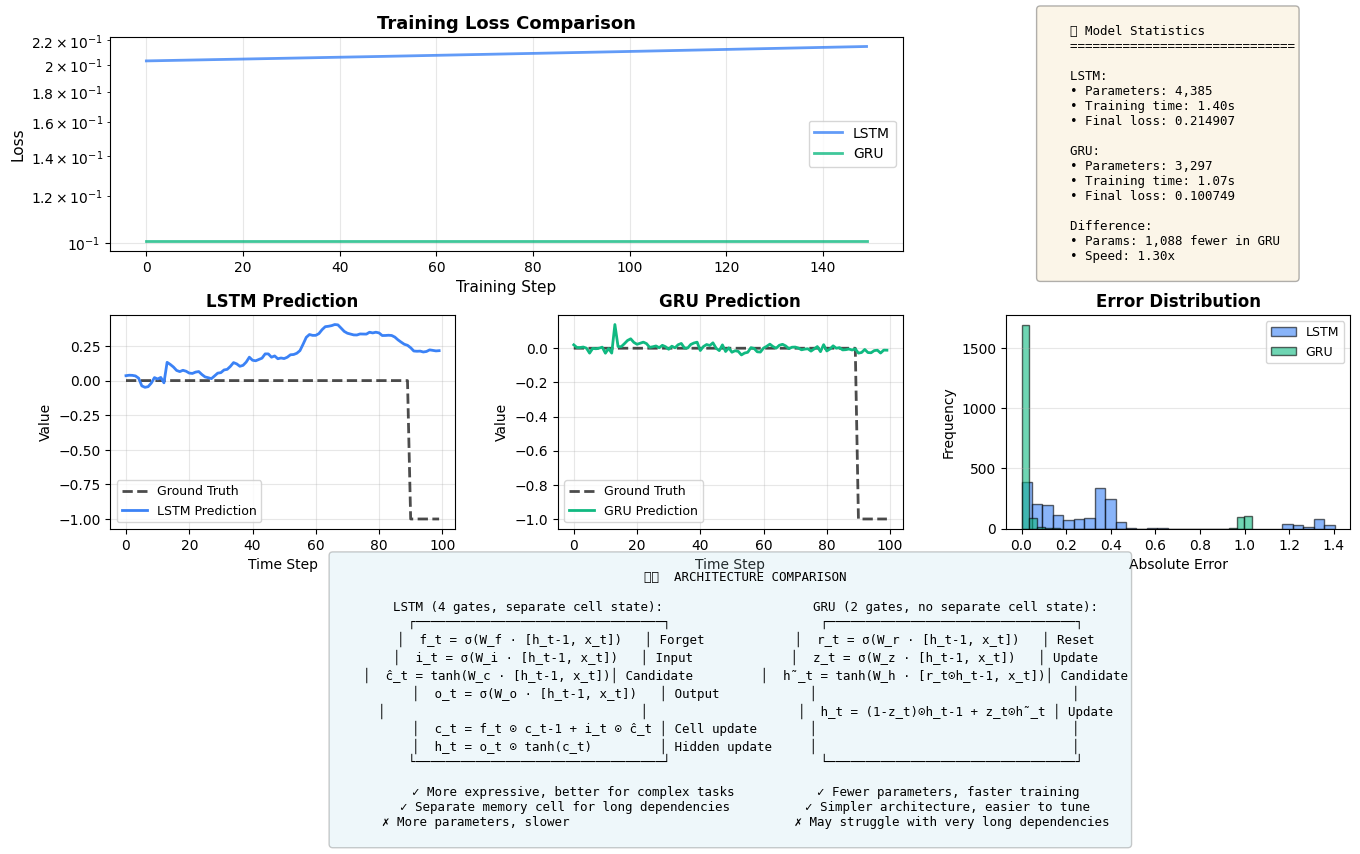


KEY TAKEAWAYS:
----------------------------------------------------------------------
1. LSTM has more parameters (4 gates vs 2) → more expressive but slower
2. GRU is simpler and faster → good for most tasks
3. LSTM may perform better on tasks requiring long-term memory
4. GRU often performs similarly with less computation
5. Choice depends on: task complexity, data size, computational budget

DEMONSTRATION COMPLETE!


In [23]:
if __name__ == "__main__":
    main()